In [1]:
import pandas as pd
import pickle as pkl

import torch,ipdb
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import platform
import time
import matplotlib.pyplot as plt
import torchviz
import hiddenlayer as hl
from torcheval.metrics import R2Score
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [2]:
print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
print(f"PyTorch Version: {torch.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.3.1-arm64-arm-64bit
PyTorch Version: 1.13.1

PyTorch Version: 1.13.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [3]:
path = '/Users/svennomm/kohalikTree/Data/AIRSCS/wave/data_v2/processed_datasets/'

with open(path + 'katse_3_4_training_data_04_19_2023_15_29_28.pkl', 'rb') as f:
    initial_data_train, initial_data_valid, target_data_train, target_data_valid, valid_index = pkl.load(f)

with open(path + 'katse_3_4_testing_data_04_19_2023_15_29_28.pkl', 'rb') as f:
    input_data_test, target_data_test, test_data_indexes = pkl.load(f)

In [4]:
X_train = initial_data_train.values
y_train = target_data_train.values

X_test = initial_data_valid.values
y_test = target_data_valid.values

X_valid = input_data_test.values
y_valid = target_data_test.values

KeyboardInterrupt: 

In [77]:
device = torch.device('mps')
def create_dataset(X_train, y_train):
    X, y = [], []
    nx, mx = X_train.shape
    ny, my = y_train.shape
    for i in range(len(X_train)):
        ax = np.transpose(X_train[i,:]).reshape([mx, 1])
        ay = np.transpose(y_train[i, :]).reshape([my, 1])
        X.append(ax)
        y.append(ay)
    return torch.tensor(X).float(), torch.tensor(y).float()

In [78]:
X_train, y_train = create_dataset(X_train, y_train)
X_test, y_test = create_dataset(X_test, y_test)
X_valid, y_valid = create_dataset(X_valid, y_valid)

#X_train, y_train = X_train.to('mps'), y_train.to('mps')
#X_test, y_test = X_test.to('mps'), y_test.to('mps')
#X_valid, y_valid = X_valid.to('mps'), y_valid.to('mps')

In [40]:
# experimental data transformation case one with pytorch

train_X = X_train.detach().cpu().numpy()[:,:,0]
train_y = y_train.detach().cpu().numpy()[:,:,0]

test_X = X_test.detach().cpu().numpy()[:,:,0]
test_y = y_test.detach().cpu().numpy()[:,:,0]

valid_X = X_valid.detach().cpu().numpy()[:,:,0]
valid_y = y_valid.detach().cpu().numpy()[:,:,0]


X_train = F.normalize(X_train)
y_train = F.normalize(y_train)

X_test = F.normalize(X_test)
y_test = F.normalize(y_test)

X_valid = F.normalize(X_valid)
y_valid = F.normalize(y_valid)



train_X_norm = X_train.detach().cpu().numpy()[:,:,0]
train_y_norm = y_train.detach().cpu().numpy()[:,:,0]

test_X_norm = X_test.detach().cpu().numpy()[:,:,0]
test_y_norm = y_test.detach().cpu().numpy()[:,:,0]

valid_X_norm = X_test.detach().cpu().numpy()[:,:,0]
valid_y_norm = y_test.detach().cpu().numpy()[:,:,0]


# very temporary!
X_train = torch.log(X_train)
log_X = X_train.detach().cpu().numpy()[:,:,0]



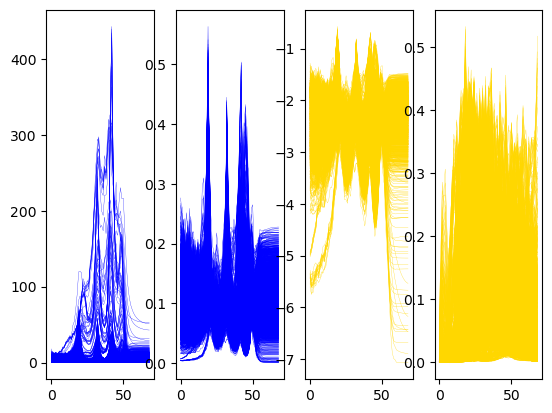

In [41]:
n = len(train_X_norm)
fig_1 = plt.figure()
ax_1_1 = fig_1.add_subplot(1, 4, 1)
ax_1_2 = fig_1.add_subplot(1, 4, 2)
ax_1_3 = fig_1.add_subplot(1, 4, 3)
ax_1_4 = fig_1.add_subplot(1, 4, 4)

for i in range(0, n):
    if i % 100 != 0:
        ax_1_1.plot(train_X[i, :], color='blue', linewidth=0.2)
        ax_1_2.plot(train_X_norm[i, :], color='blue', linewidth=0.2)
        ax_1_3.plot(log_X[i, :], color='gold', linewidth=0.2)
        ax_1_4.plot(train_y_norm[i, :], color='gold', linewidth=0.2)
plt.show()

# n =len(test_X_norm)
# fig_2 = plt.figure()
# ax_2_1 = fig_2.add_subplot(1, 4, 1)
# ax_2_2 = fig_2.add_subplot(1, 4, 2)
# ax_2_3 = fig_2.add_subplot(1, 4, 3)
# ax_2_4 = fig_2.add_subplot(1, 4, 4)
#
# for i in range(0, n):
#     if i % 100 != 0:
#         ax_2_1.plot(test_X[i, :], color='blue', linewidth=0.2)
#         ax_2_2.plot(test_X_norm[i, :], color='blue', linewidth=0.2)
#         ax_2_3.plot(test_y[i, :], color='gold', linewidth=0.2)
#         ax_2_4.plot(test_y_norm[i, :], color='gold', linewidth=0.2)
# plt.show()


In [79]:
import torch
import torch.nn as nn

class LSTMSimple(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMSimple, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input sequence through LSTM layer
        lstm_out, _ = self.lstm(x)

        # Pass LSTM output through fully-connected layer
        out = self.fc(lstm_out)

        return out


In [72]:
print(X_train.size(),y_train.size() )

torch.Size([2772, 69, 1]) torch.Size([2772, 69, 1])


In [82]:
lstm_model = LSTMSimple(input_size=1, hidden_size=4, num_layers=2, output_size=1)


batch_size = 200
# Create a TensorDataset to represent your input and target sequences

train_dataset = TensorDataset(X_train, y_train)

# Create a DataLoader to load your training data in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define your loss function
loss_fn = torch.nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 100

# Train your model
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm_model(batch_X)

        # Compute the loss
        loss = loss_fn(outputs, batch_y)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

    # Print the loss for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/100], Loss: 0.5912
Epoch [2/100], Loss: 0.9077
Epoch [3/100], Loss: 0.7664
Epoch [4/100], Loss: 1.1084
Epoch [5/100], Loss: 0.5996
Epoch [6/100], Loss: 0.5127
Epoch [7/100], Loss: 0.6709
Epoch [8/100], Loss: 0.8711
Epoch [9/100], Loss: 0.5987
Epoch [10/100], Loss: 0.8036
Epoch [11/100], Loss: 0.7658
Epoch [12/100], Loss: 0.8402
Epoch [13/100], Loss: 0.6592
Epoch [14/100], Loss: 0.6917
Epoch [15/100], Loss: 0.7754
Epoch [16/100], Loss: 0.6131
Epoch [17/100], Loss: 0.8880
Epoch [18/100], Loss: 0.5859
Epoch [19/100], Loss: 0.4190
Epoch [20/100], Loss: 0.5645
Epoch [21/100], Loss: 0.4343
Epoch [22/100], Loss: 0.6052
Epoch [23/100], Loss: 0.9729
Epoch [24/100], Loss: 0.6820
Epoch [25/100], Loss: 0.4792
Epoch [26/100], Loss: 0.7801
Epoch [27/100], Loss: 0.5548
Epoch [28/100], Loss: 0.5237
Epoch [29/100], Loss: 0.5611
Epoch [30/100], Loss: 0.4924
Epoch [31/100], Loss: 0.9930
Epoch [32/100], Loss: 0.7167
Epoch [33/100], Loss: 0.6234
Epoch [34/100], Loss: 0.4864
Epoch [35/100], Loss: 0

In [7]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.lstm_1 = nn.LSTM(64, 64, 1)
        self.lstm_2 = nn.LSTM(64, 64, 1)
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)
        x = self.linear(x)
        return x

In [31]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=200)
metric = R2Score()

rmse_train = []
rmse_test = []

NameError: name 'AirModel' is not defined

In [33]:
n_epochs = 20
for epoch in range(n_epochs):
    start = time.time()
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    #if epoch % 100 != 0:
        #continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        rmse_train.append(train_rmse)
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        rmse_test.append(test_rmse)

        #metric.update(y_pred, y_train)
        #train_r2 = metric.compute()
        #print(train_r2)

        #metric.update(y_pred, y_test)
        #test_r2 = metric.compute()
        #print(test_r2)

    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    end = time.time()
    print(end - start)

/Users/svennomm/miniconda3/envs/pytorch_ds/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([200, 69, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (200) must match the size of tensor b (69) at non-singleton dimension 1

In [85]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(X_valid) * np.nan
    y_pred = model(X_valid)

    #train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    #test_plot = np.ones_like(timeseries) * np.nan
    #test_plot[train_size + lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot

y_pred = y_pred.detach().cpu().numpy()[:,:,0]
X_valid = X_valid.detach().cpu().numpy()[:,:,0]
y_valid = y_valid.detach().cpu().numpy()[:,:,0]

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

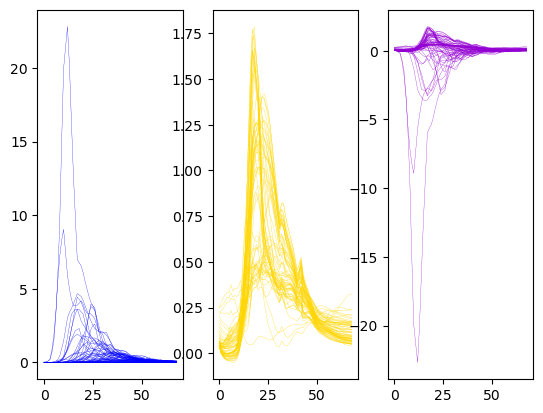

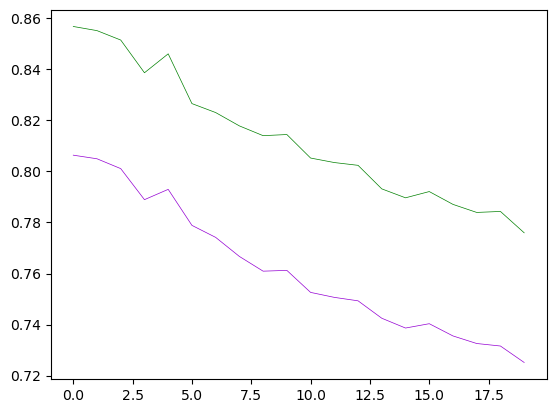

In [11]:
residuals = y_pred - y_valid
n, m = y_pred.shape


fig_1 = plt.figure()
ax_1_1 = fig_1.add_subplot(1, 3, 1)
ax_1_2 = fig_1.add_subplot(1, 3, 2)
ax_1_3 = fig_1.add_subplot(1, 3, 3)

for i in range(0, n):
    ax_1_1.plot(y_valid[i, :], color='blue', linewidth=0.2)
    ax_1_2.plot(y_pred[i, :], color='gold', linewidth=0.2)
    ax_1_3.plot(residuals[i, :], color='darkviolet', linewidth=0.2)

plt.show()

fig_2 = plt.figure()
plt.plot(rmse_test, color = 'green', linewidth = 0.5)
plt.plot(rmse_train, color = 'darkviolet', linewidth = 0.5)
plt.show()

In [12]:
def goodness_descriptor(test_y, hat_y):
    mse = mean_squared_error(test_y, hat_y)
    rho = np.corrcoef(test_y, hat_y)[0, 1]
    max_test = test_y.argmax(axis=0)
    max_hat = hat_y.argmax(axis=0)
    delta_max_val = np.max(test_y) - np.max(hat_y)
    delta_max_loc = max_test - max_hat

    return mse, rho, max_test, max_hat, delta_max_val, delta_max_loc

In [13]:
goodness_descriptors = []

for i in range(0, len(y_pred)):
    mse, rho, max_test, max_hat, delta_max_val, delta_max_loc = goodness_descriptor(y_valid[i, :], y_pred[i, :])
    goodness_descriptors.append([int(test_data_indexes[i]), mse, rho, max_test, max_hat, delta_max_val, delta_max_loc])

goodness_descriptors = np.array(goodness_descriptors)
columns = ['index', 'mse', 'rho', 'max_test', 'max_hat', 'delta_max_val', 'delta_max_loc']
print(columns)
print("Average values are: ", np.average(goodness_descriptors, axis=0))
goodness_descriptors = pd.DataFrame(goodness_descriptors, columns=columns)

['index', 'mse', 'rho', 'max_test', 'max_hat', 'delta_max_val', 'delta_max_loc']
Average values are:  [1.94922667e+03 8.44199325e-01 2.47857637e-01 3.33600000e+01
 2.04933333e+01 2.31395275e-01 1.28666667e+01]


In [14]:
goodness_descriptors

,index,mse,rho,max_test,max_hat,delta_max_val,delta_max_loc
0,1426.0,0.019556,-0.412524,28.0,6.0,0.085713,22.0
1,5.0,0.065842,0.142577,60.0,19.0,-0.604797,41.0
2,1450.0,0.061914,-0.234823,36.0,18.0,0.356444,18.0
3,4360.0,0.111923,0.864504,26.0,26.0,0.902828,0.0
4,4174.0,0.703303,0.844177,24.0,23.0,2.862006,1.0
...,...,...,...,...,...,...,...
70,3684.0,0.083250,0.904369,18.0,17.0,0.641739,1.0
71,1423.0,0.190175,0.033095,32.0,18.0,-0.551552,14.0
72,49.0,0.308505,0.026139,36.0,23.0,-1.128138,13.0
73,682.0,0.076605,0.907837,20.0,18.0,-0.760648,2.0
